# WORKGROUP 4 -  GROUP 7

In [18]:
import hdmpy
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import pandas as pd
import statsmodels.formula.api as smf
import pyreadr

# Orthogonal method vs Naive Method estimators

In this section we are going to compare the Orthogonal Method with the Nive Method to estimate parameters of a previously setted Data Generating Process (DGP). We expecto to estimate more precise parameter with the orthogonal method than with the Naive Method.

In [3]:
# Set seed
np.random.seed(420247)

nai = {}
ort = {}

In [4]:
seq  = np.array([50, 100, 1000])
for j in seq:
   
    B = j
    nai["sim{0}".format(j)] = np.zeros( B )
    ort["sim{0}".format(j)] = np.zeros( B )
  
    
    for i in range( 0, B ):
        n = 100
        p = 100
        beta = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )
        gamma = ( 1 / (np.arange( 1, p + 1 ) ** 2 ) ).reshape( p , 1 )

        mean = 0
        sd = 1
        X = np.random.normal( mean , sd, n * p ).reshape( n, p )

        D = ( X @ gamma ) + np.random.normal( mean , sd, n ).reshape( n, 1 )/4 # We reshape because in r when we sum a vecto with a matrix it sum by column
        D = D
        # DGP 
        Y = 5*D + ( X @ beta ) + np.random.normal( mean , sd, n ).reshape( n, 1 )

    # single selection method
        r_lasso_estimation = hdmpy.rlasso( np.concatenate( ( D , X ) , axis  =  1 ) , Y , post = True ) # Regress main equation by lasso

        coef_array = r_lasso_estimation.est[ 'coefficients' ].iloc[ 2:, :].to_numpy()    # Get "X" coefficients 

        SX_IDs = np.where( coef_array != 0 )[0]

    # In case all X coefficients are zero, then regress Y on D
        if sum(SX_IDs) == 0 : 
            nai["sim{0}".format(j)][i-1] = sm.OLS( Y , sm.add_constant(D) ).fit().summary2().tables[1].round(3).iloc[ 1, 0 ] 

    # Otherwise, then regress Y on X and D (but only in the selected coefficients)
        elif sum( SX_IDs ) > 0 :
            X_D = np.concatenate( ( D, X[:, SX_IDs ] ) , axis = 1 )
            nai["sim{0}".format(j)][i-1] = sm.OLS( Y , sm.add_constant( X_D ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]
            
    # In both cases we save D coefficient
        
    # Regress residuals. 
        resY = hdmpy.rlasso( X , Y , post = False ).est[ 'residuals' ]
        resD = hdmpy.rlasso( X , D , post = False ).est[ 'residuals' ]
        ort["sim{0}".format(j)][i-1] = sm.OLS( resY , sm.add_constant( resD ) ).fit().summary2().tables[1].round(3).iloc[ 1, 0]

In [13]:
orth50  = pd.DataFrame.from_dict(ort['sim50'])
orth100 = pd.DataFrame.from_dict(ort['sim100'])
orth1000 = pd.DataFrame.from_dict(ort['sim1000'])

naive50   = pd.DataFrame.from_dict(nai['sim50'])
naive100  = pd.DataFrame.from_dict(nai['sim100'])
naive1000 = pd.DataFrame.from_dict(nai['sim1000'])

In [14]:
Orto_breaks = [-1.2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
Naive_breaks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2]

Orto_breaks  = np.arange(-1.2, 2, 0.05)
Orto_breaks  = Orto_breaks.tolist()
Naive_breaks = np.arange(-0.6, 1.2, 0.05)
Naive_breaks  = Naive_breaks.tolist()

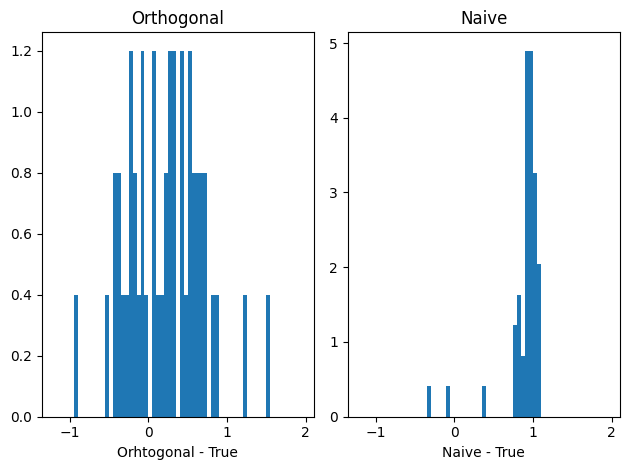

In [15]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( orth50 - 5 , range = (-2, 2), density = True , bins = Orto_breaks )
axs[1].hist( naive50 - 5, range = (-2, 2), density = True , bins = Naive_breaks )

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )

plt.show()

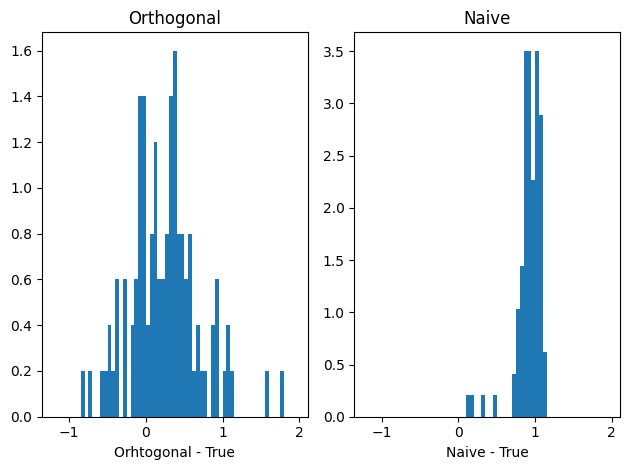

In [16]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( orth100 - 5 , range = (-2, 2), density = True , bins = Orto_breaks )
axs[1].hist( naive100 - 5, range = (-2, 2), density = True , bins = Naive_breaks )

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )

plt.show()

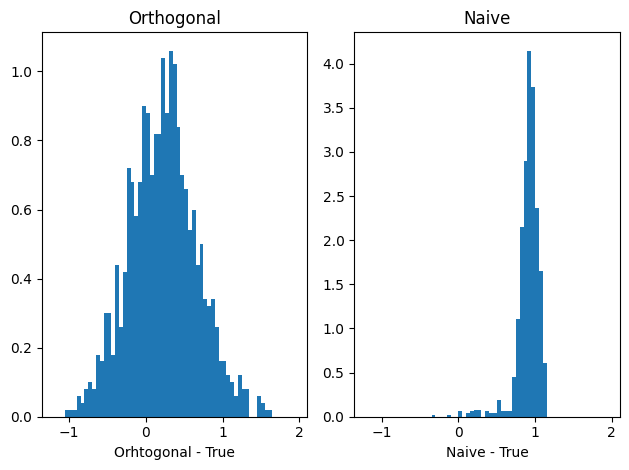

In [17]:
fig, axs = plt.subplots(1, 2, sharex= True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist( orth1000 - 5 , range = (-1.5, 1.5), density = True , bins = Orto_breaks )
axs[1].hist( naive1000 - 5, range = (-2, 2), density = True , bins = Naive_breaks )

axs[0].title.set_text('Orthogonal')
axs[1].title.set_text('Naive')

axs[0].set_xlabel( 'Orhtogonal - True' )
axs[1].set_xlabel( 'Naive - True' )
plt.show()

Histograms show an expected pattern that mantains even when we increase the number of simulations. We would expect that the histograms are centered on 0 since the DGP is denoted by:

\begin{align}
\ Y &=\rho D  + \beta' W + \epsilon_1 \\
\ \rho = 5 \\
\ D &=\gamma' W + \epsilon_2 \\
\end{align}

And since we asked for the histogram of $\hat{\rho}$ - $5$.

* Orthogonal estimators: The histogram of the estimators  obtained by the Double Lasso is centered on 0.  These estimation method takes advantage of the Neyman Orthogonality.
* Naive estimators: The histogram of the estimators obtained by the naive approach is not centered on 0. This means that the Naviwe method, in average, does estimate biased parameters


Since we defined in the DGP that the Variable of interest $D$ is a function of the $X$ covariates, we expecto to obtain biased estimators when using the Naive Method . Therefore the Naive method estimators are biased because the doesn't get rid of some variables effects that could be affecting the result variable $Y$. On the other hand, the second method gets rid of other variables effect on $D$ and in the next step obtains unbiased estimators as we could seen. 

# Double Lasso

We know that the Lasso approach is useful for estimating a model with a large number of covariates relative to the number of observations (when $\frac{p}{n}$ is not small). The Double Lasso method efficiently selects the relevant covariates for said estimation through two Lasso regression and an OLS one. 

We want to estimate the following equation:

\begin{equation}\label{original}
Y = \alpha D + \beta 'W+ \epsilon_1 \tag{1}.
\end{equation}

Where  D is our variable of interest, and W is a set of control variables.

The Double Lasso approach consists of estimating $(2)$ and $(3)$ via Lasso:

\begin{equation}\label{Y}
Y = \gamma_{YW} 'W+ \mu_{YW} \tag{2}
\end{equation}

\begin{equation}\label{D}
D = \gamma_{DW} 'W+ \mu_{DW} \tag{3}
\end{equation}

Once we run these regressions, we estimate the error of each equation, that is $\hat\mu_{YW}$ and $\hat\mu_{DW}$.

Finally, we estimate $(4)$ using OLS:

\begin{equation}\label{mu}
\hat\mu_{YW} = \alpha\hat\mu_{DW}+ \epsilon_2 \tag{4}
\end{equation}

Note that the parameter $\alpha$ is the same as the one obtained from $(1)$.


## Replication

In this case, we test the convergence hypothesis proposed by Solow-Swan. We propose the following model:

  $$
  Y = \beta_1 D +  \beta_2'W + \epsilon.
  $$
  
Where $Y$ is the growth rate of a certain country, $D$ is the initial wealth level of said country, and $W$ is a set of control variables related to each country's institutional, educational, and similar characteristics.

In [19]:
# Importing the data
growth_read = pyreadr.read_r("data/GrowthData.RData")

# Extracting the data frame from rdata_read
growth = growth_read[ 'GrowthData' ]
list(growth)

['Outcome',
 'intercept',
 'gdpsh465',
 'bmp1l',
 'freeop',
 'freetar',
 'h65',
 'hm65',
 'hf65',
 'p65',
 'pm65',
 'pf65',
 's65',
 'sm65',
 'sf65',
 'fert65',
 'mort65',
 'lifee065',
 'gpop1',
 'fert1',
 'mort1',
 'invsh41',
 'geetot1',
 'geerec1',
 'gde1',
 'govwb1',
 'govsh41',
 'gvxdxe41',
 'high65',
 'highm65',
 'highf65',
 'highc65',
 'highcm65',
 'highcf65',
 'human65',
 'humanm65',
 'humanf65',
 'hyr65',
 'hyrm65',
 'hyrf65',
 'no65',
 'nom65',
 'nof65',
 'pinstab1',
 'pop65',
 'worker65',
 'pop1565',
 'pop6565',
 'sec65',
 'secm65',
 'secf65',
 'secc65',
 'seccm65',
 'seccf65',
 'syr65',
 'syrm65',
 'syrf65',
 'teapri65',
 'teasec65',
 'ex1',
 'im1',
 'xr65',
 'tot1']

In [20]:
growth.shape

(90, 63)

We note that we have $90$ countries, but $63$ control variables, which means we have a relatively large number of variables for a relatively small number of observations ($\frac{p}{n}$ not small). Hence, we would expect the OLS regression to perform poorly, and a Lasso regression to estimate a better $\beta_1$. In the following sections, we compare how different estimation methods perform when it comes to estimating the speed of convergence.

In [22]:
# We create the main variables
y = growth['Outcome']
X = growth.drop('Outcome', 1)

<ipython-input-22-8ba339c4a057>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = growth.drop('Outcome', 1)


## Method 1: OLS

Here we perform a simple OLS regression.

In [23]:
#OLS regression

reg_ols  = sm.OLS(y, X).fit()
print(reg_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                Outcome   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     3.607
Date:                Fri, 08 Oct 2021   Prob (F-statistic):           0.000200
Time:                        14:36:45   Log-Likelihood:                 238.24
No. Observations:                  90   AIC:                            -352.5
Df Residuals:                      28   BIC:                            -197.5
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2472      0.785      0.315      0.7

We create a table to summarize the results of the OLS estimation:

In [25]:
# output: estimated regression coefficient corresponding to the target regressor
est_ols = reg_ols.summary2().tables[1]['Coef.']['gdpsh465']

# output: std. error
std_ols = reg_ols.summary2().tables[1]['Std.Err.']['gdpsh465']

# output: t-statistic
tst_ols = reg_ols.summary2().tables[1]['P>|t|']['gdpsh465']

# output: 95% confidence interval
lower_ci = reg_ols.summary2().tables[1]['[0.025']['gdpsh465']
upper_ci = reg_ols.summary2().tables[1]['0.975]']['gdpsh465']


table_1 = np.zeros( (1, 5) )

table_1[0,0] = est_ols  
table_1[0,1] = std_ols 
table_1[0,2] = tst_ols
table_1[0,3] = lower_ci
table_1[0,4] = upper_ci    


table_1_pandas = pd.DataFrame( table_1, columns = [ "Estimator","Std. Error","P>|t|", "Lower bound CI", "Upper bound CI"  ])
table_1_pandas.index = [ "OLS" ]
table_1_pandas

,Estimator,Std. Error,P>|t|,Lower bound CI,Upper bound CI
OLS,-0.009378,0.029888,0.756019,-0.0706,0.051844


In this case, $\beta_1 \approx -0.0094$ which is consistent with the convergence hypothesis, which indicates that poor countries do catch up with wealthier countries. However, we note that this estimator is not significant, given the $t-statistic$ and the confidence interval.

So, it is better to test how Lasso would perform. For this, we will use the double lasso aproach, with different tools, following the steps previously indicated.

In [27]:
# First, we create main variables
Y = growth['Outcome']
W = growth.drop(['Outcome','intercept', 'gdpsh465'], 1 )
D = growth['gdpsh465']

<ipython-input-27-67f5009a8677>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  W = growth.drop(['Outcome','intercept', 'gdpsh465'], 1 )


## Method 2: Double Lasso with Cross Validation
For this, we will use the sklearn package. We do not especify the splitting strategy, being the default a 5-fold cross-validation.

In [28]:
from sklearn.linear_model import LassoCV

# Set values for Lasso
lasso_model = LassoCV()
r_Y = Y - lasso_model.fit( W, Y ).predict( W )
r_Y = r_Y.rename('r_Y')

# Part. out d
r_D = D - lasso_model.fit( W, D ).predict( W )
r_D = r_D.rename('r_D')

# ols 
partial_lasso_fit = sm.OLS(r_Y, r_D).fit()

partial_lasso_fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
===============================================================================
Model:                  OLS              Adj. R-squared (uncentered): -0.011   
Dependent Variable:     r_Y              AIC:                         -283.5568
Date:                   2021-10-08 14:37 BIC:                         -281.0569
No. Observations:       90               Log-Likelihood:              142.78   
Df Model:               1                F-statistic:                 0.0002799
Df Residuals:           89               Prob (F-statistic):          0.987    
R-squared (uncentered): 0.000            Scale:                       0.0024799
------------------------------------------------------------------------------------
              Coef.       Std.Err.         t         P>|t|        [0.025      0.975]
------------------------------------------------------------------------------------
r_D          -0.0002        0.0091      -0.0167      0.9867      -0.0183      0.0180
-------------------------------------------------------------------------------
Omnibus:                   2.910             Durbin-Watson:               1.510
Prob(Omnibus):             0.233             Jarque-Bera (JB):            2.306
Skew:                      -0.249            Prob(JB):                    0.316
Kurtosis:                  3.605             Condition No.:               1    
===============================================================================

"""

We store the results:

In [30]:
est_lasso = partial_lasso_fit.summary2().tables[1]['Coef.']['r_D']
std_lasso = partial_lasso_fit.summary2().tables[1]['Std.Err.']['r_D']
tst_lasso = partial_lasso_fit.summary2().tables[1]['P>|t|']['r_D']
lower_ci_lasso = partial_lasso_fit.summary2().tables[1]['[0.025']['r_D']
upper_ci_lasso = partial_lasso_fit.summary2().tables[1]['0.975]']['r_D']

table_2 = np.zeros( (1, 5) )

table_2[0,0] = est_lasso  
table_2[0,1] = std_lasso
table_2[0,2] = tst_lasso
table_2[0,3] = lower_ci_lasso
table_2[0,4] = upper_ci_lasso


table_2_pandas = pd.DataFrame( table_2, columns = [ "Estimator","Std. Error","P>|t|", "Lower bound CI", "Upper bound CI"  ])
table_2_pandas.index = [ "Lasso_CV" ]
table_2_pandas

,Estimator,Std. Error,P>|t|,Lower bound CI,Upper bound CI
Lasso_CV,-0.000153,0.009147,0.98669,-0.018328,0.018022


Here we notice that, just like the OLS estimation, the $\beta_1$ obtained from Lasso with Cross Validation is not statistically significant, and is still negative. It is worth noticing that the Cross-Validation method is used to assess the predictive accuracy of a model. In this case, we notice that the predictive model performs poorly.

## Method 3: Double Lasso with Theorical Lambda
For this method, we use the HDM package.

In [33]:
#Partialling out
res_Y = hdmpy.rlasso( W, Y, post=True ).est['residuals']
res_D = hdmpy.rlasso( W, D, post=True ).est['residuals']

r_Y = pd.DataFrame(res_Y, columns=['r_Y'])
r_D = pd.DataFrame(res_D, columns=['r_D'])

# OLS regression
reg_ols  = sm.OLS(r_Y, r_D).fit()
print(reg_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                    r_Y   R-squared (uncentered):                   0.127
Model:                            OLS   Adj. R-squared (uncentered):              0.117
Method:                 Least Squares   F-statistic:                              12.92
Date:                Fri, 08 Oct 2021   Prob (F-statistic):                    0.000533
Time:                        14:38:44   Log-Likelihood:                          152.68
No. Observations:                  90   AIC:                                     -303.4
Df Residuals:                      89   BIC:                                     -300.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

We store the results:

In [35]:
est_hdm = reg_ols.summary2().tables[1]['Coef.']['r_D']
std_hdm = reg_ols.summary2().tables[1]['Std.Err.']['r_D']
tst_hdm = reg_ols.summary2().tables[1]['P>|t|']['r_D']
lower_ci_hdm = reg_ols.summary2().tables[1]['[0.025']['r_D']
upper_ci_hdm = reg_ols.summary2().tables[1]['0.975]']['r_D']

table_3 = np.zeros( (1, 5) )

table_3[0,0] = est_hdm   
table_3[0,1] = std_hdm 
table_2[0,2] = tst_hdm
table_3[0,3] = lower_ci_hdm
table_3[0,4] = upper_ci_hdm    


table_3_pandas = pd.DataFrame( table_3, columns = [  "Estimator","Std. Error","P>|t|", "Lower bound CI", "Upper bound CI"  ]) 
table_3_pandas.index = [ "Lasso_HDM" ]
table_3_pandas

,Estimator,Std. Error,P>|t|,Lower bound CI,Upper bound CI
Lasso_HDM,-0.049811,0.013858,0.0,-0.077347,-0.022276


In this estimation, we obtain a negative, statistically significant $\beta_1$, which confirms the convergence hypothesis of the Solow-Swan model.

## Method 4: Double Lasso with Partialling Out, Direct 

In this case, we use de HDM package, but with the _method="partialling out"_, a direct way for partialling out.

In [37]:
lasso_direct = hdmpy.rlassoEffect(x=W, y=Y, d=D, method="partialling out")
lasso_direct

{'alpha': -0.04981144483733837,
 'se': array([0.01539133]),
 't': array([-3.23633167]),
 'pval': array([0.00121077]),
 'coefficients': -0.04981144483733837,
 'coefficient': -0.04981144483733837,
 'coefficients_reg':                     0
 (Intercept)  0.058101
 x0          -0.075565
 x1           0.000000
 x2           0.000000
 x3           0.000000
 ...               ...
 x55          0.000000
 x56          0.000000
 x57          0.000000
 x58          0.000000
 x59          0.000000
 
 [61 rows x 1 columns],
 'selection_index': array([[ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
     

We store the results:

In [39]:
est_lasso_direct = lasso_direct["coefficients"]
std_lasso_direct = lasso_direct["se"]
tst_lasso_direct= lasso_direct["pval"]
lower_ci_lasso_direct = est_lasso_direct - 1.96*std_lasso
upper_ci_lasso_direct = est_lasso_direct + 1.96*std_lasso


table_4 = np.zeros( (1, 5) )

table_4[0,0] = est_lasso_direct   
table_4[0,1] = std_lasso_direct
table_4[0,2] = tst_lasso_direct
table_4[0,3] = lower_ci_lasso_direct 
table_4[0,4] = upper_ci_lasso_direct     


table_4_pandas = pd.DataFrame( table_4, columns = [ "Estimator","Std. Error","P>|t|", "Lower bound CI", "Upper bound CI"  ]) 
table_4_pandas.index = [ "Lasso_Direct" ]
table_4_pandas

,Estimator,Std. Error,P>|t|,Lower bound CI,Upper bound CI
Lasso_Direct,-0.049811,0.015391,0.001211,-0.067739,-0.031884


As the former Lasso estimation, here too we obtain a negative, statistically significant $\beta_1$.

## Summary and Plot
Here we summarize the four methods used to estimate $\beta_1$.

In [40]:
tables=[table_1_pandas,table_2_pandas,table_3_pandas,table_4_pandas]
summary=pd.concat(tables)
summary

,Estimator,Std. Error,P>|t|,Lower bound CI,Upper bound CI
OLS,-0.009378,0.029888,0.756019,-0.070600,0.051844
Lasso_CV,-0.000153,0.009147,0.000533,-0.018328,0.018022
Lasso_HDM,-0.049811,0.013858,0.000000,-0.077347,-0.022276
Lasso_Direct,-0.049811,0.015391,0.001211,-0.067739,-0.031884


We notice that OLS performs the worst of all models, estimating a $\beta_1$ with the highest standard error. The Cross-Validation method also performs poorly, estimating a non-statisically significant $\beta_1$. All the other Lasso methods estimate a statistically significant $\beta_1 \approx -0.048$. Overall, we can confirm the convergence hypothesis of the Solow-Swan model, which tells us that poor countries grow faster than wealthier countries.

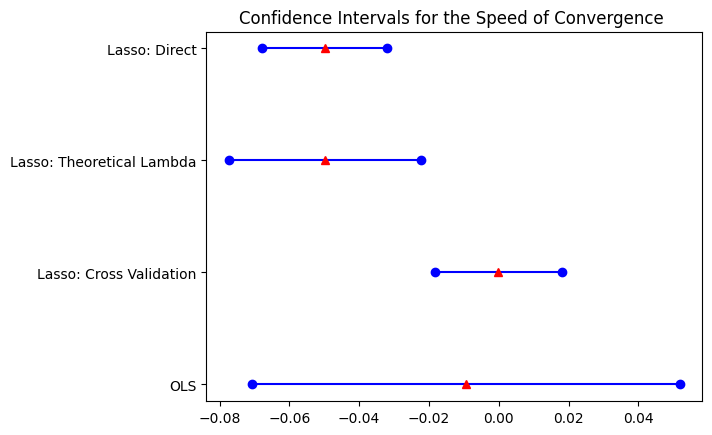

In [41]:
for lower,upper,coef,y in zip(summary['Lower bound CI'],summary['Upper bound CI'],summary['Estimator'],range(len(summary))):
    plt.plot((lower,upper),(y,y),'o-',color='blue')
    plt.plot(coef,y,'^',color='red')

plt.yticks(range(len(summary)),list(['OLS', 'Lasso: Cross Validation', 'Lasso: Theoretical Lambda', 'Lasso: Direct']))
plt.title('Confidence Intervals for the Speed of Convergence ')

    
plt.show()

Here, we can visually appreciate how the OLS method estimates the $\beta_1$ with the largest confidence interval that includes zero. While Lasso with Cross-Validation has a narrower confidence interval, it still includes zero. We can also notice that Lasso with the direct method estimates the $\beta_1$ with the narrowest confidence interval.